In [8]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from load import load_data

<Axes: xlabel='time'>

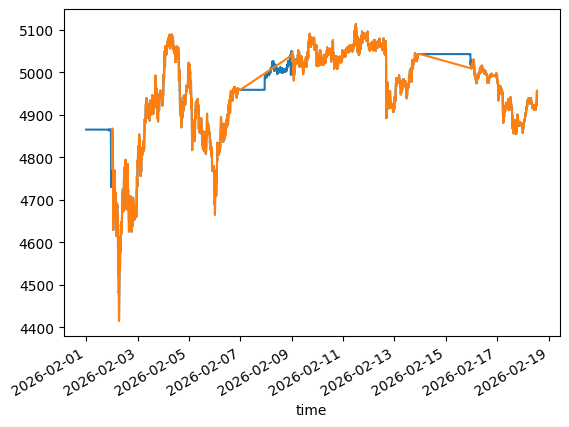

In [9]:
raw_df = load_data("twelve_data", "xauusd", "5min", data_dir="data/fin-loader-data")

raw_df.close.plot()

weekday = raw_df.index.weekday
hour = raw_df.index.hour
raw_df = raw_df[((weekday >= 0) & (weekday <= 4))]  # week day only

raw_df.close.plot()

In [10]:
raw_df["week_id"] = raw_df.index.to_period("W")
weekly_groups = raw_df.groupby("week_id")

chunks = []
for week, chunk in weekly_groups:
    print(week, len(chunk))
    chunks.append(chunk.drop("week_id", axis=1))

2026-02-02/2026-02-08 1440
2026-02-09/2026-02-15 1440
2026-02-16/2026-02-22 735


/var/folders/zv/gdz2_9196fl_tmklfm9c46km0000gn/T/ipykernel_45797/2285549943.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  raw_df["week_id"] = raw_df.index.to_period("W")


In [11]:
def backtest(df, short_period, long_period):
    df = df.copy()
    lst_pnl = []

    df['short_sma'] = df["close"].rolling(short_period).mean()
    df['long_sma'] = df["close"].rolling(long_period).mean()

    # df["sma20"] = df["close"].rolling(20).mean()
    # df["std20"] = df["close"].rolling(20).std()
    # k = 2
    # df["upper_band"] = df["sma20"] + k*df["std20"]
    # df["lower_band"] = df["sma20"] - k*df["std20"]

    order = None
    for ts, row in df.iterrows():
        close = row.close

        order_pnl = 0
        if order:
            if order[0] == "buy": order_pnl = close - order[1]
            else: order_pnl = -(close - order[1])

        pnl = lst_pnl[-1] if lst_pnl else 0
        if row['short_sma'] > row['long_sma']:
            if order and order[0] == "sell":
                pnl += order_pnl
                order = None
            if not order: order = ("buy", close)
        else:
            if order and order[0] == "buy":
                pnl += order_pnl
                order = None
            if not order: order = ("sell", close)

        lst_pnl.append(pnl)

    return df, lst_pnl

def plot_backtest(df, lst_pnl, title):
    df = df.copy()
    df.reset_index(inplace=True)

    fig, axes = plt.subplots(2, 1, sharex=True, height_ratios=[2, 1], figsize=(15, 8))
    
    axes[0].set_title(title)
    axes[0].plot(df.close)
    axes[0].plot(df.short_sma)
    axes[0].plot(df.long_sma)
    # axes[0].plot(df.upper_band)
    # axes[0].plot(df.lower_band)

    axes[1].axhline(0, color="black", lw=1)
    axes[1].plot(lst_pnl)

    return fig, axes

In [15]:
from pathlib import Path

imgs = Path("imgs")
imgs.mkdir(exist_ok=True)

start = 20
end = 101
step = 20
for s in range(start, end, step):
    for l in range(start, end, step):
        if s >= l:
            continue
        df, lst_pnl = backtest(chunks[0], s, l)
        title = f"short={s}_long={l}"
        fig, axes = plot_backtest(df, lst_pnl, title)
        fig.savefig(imgs / title)
        plt.close(fig)

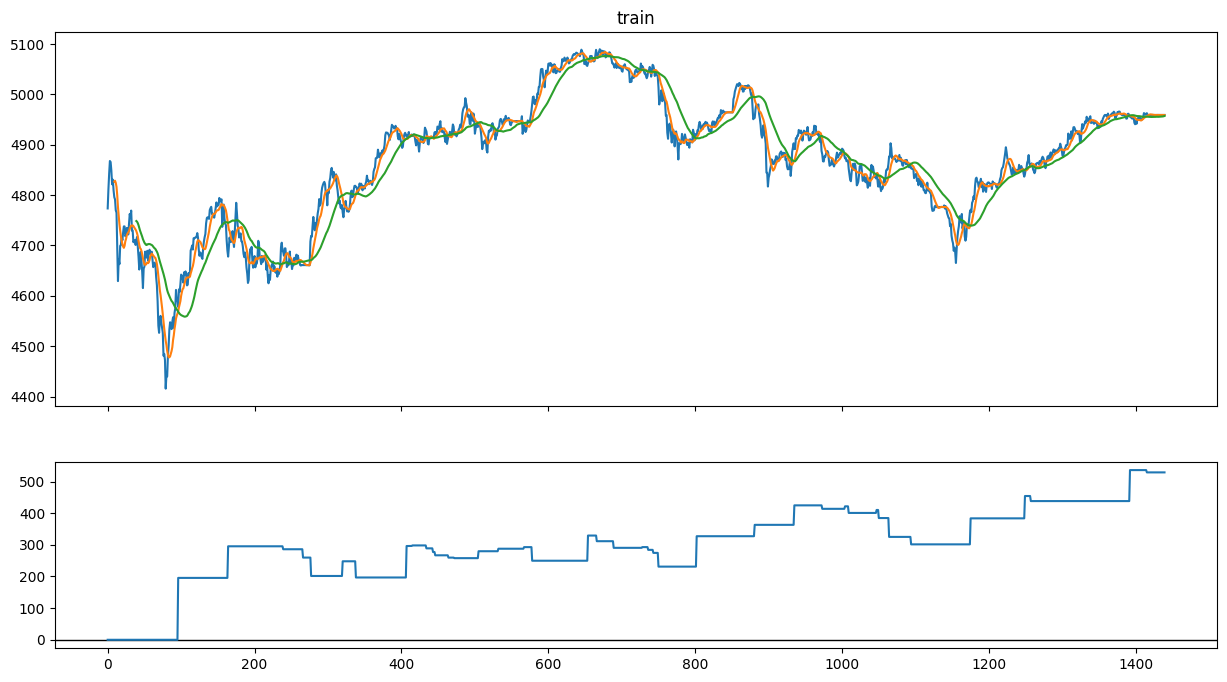

In [13]:
df, lst_pnl = backtest(chunks[0], 10, 40)
fig, axes = plot_backtest(df, lst_pnl, "train")

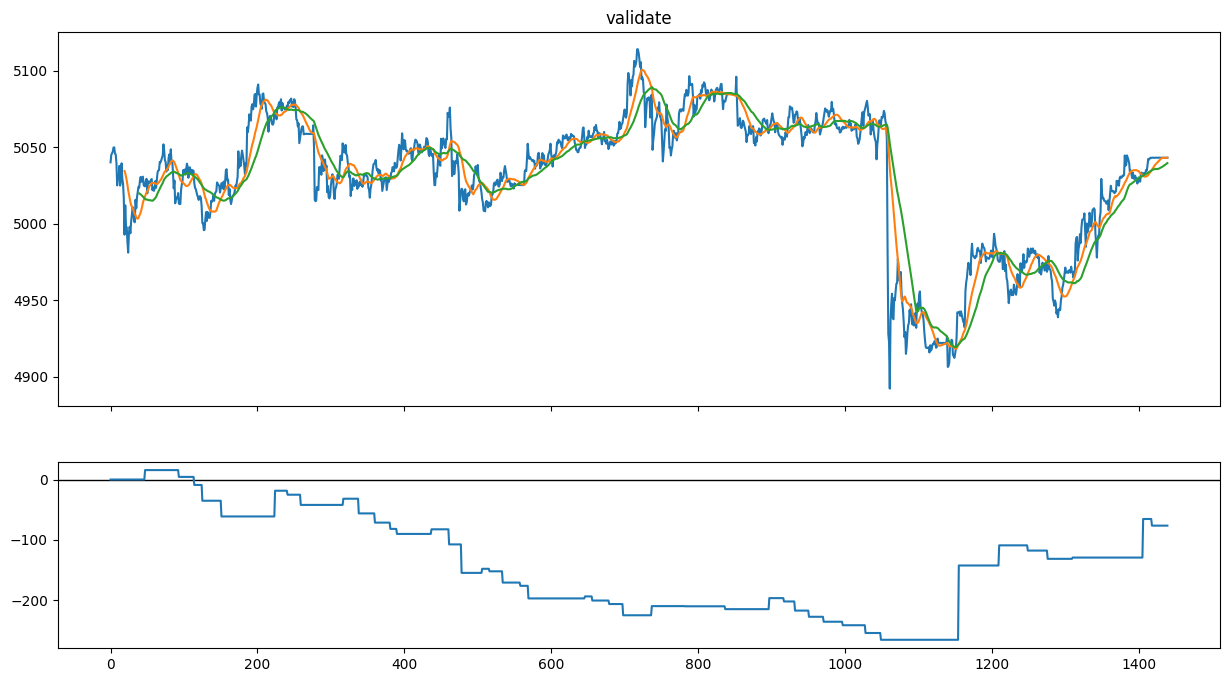

In [16]:
df, lst_pnl = backtest(chunks[1], 20, 40)
fig, axes = plot_backtest(df, lst_pnl, "validate")